## Run SimSS simulations and plot the results
Version 0.1
(c) Vincent M. Le Corre (https://github.com/VMLC-PV)

In [2]:
# Package import
%matplotlib inline
%matplotlib widget
# %matplotlib notebook
# comment the above line if you don't want interactive plots
import os,platform,warnings,time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.lines import Line2D
# Import homemade package by VLC
from SIMsalabim_utils.GetInputPar import * # Get input parameters
from SIMsalabim_utils.RunSim import * # Run simulation
from SIMsalabim_utils.ZimT_plots import * # Plotting functions
from SIMsalabim_utils.CleanFolder import clean_up_output, clean_file_type # Cleaning functions
from SIMsalabim_utils import plot_settings_screen # Plot settings
from SIMsalabim_utils.aux_func import * # Auxiliary functions
## General Inputs
warnings.filterwarnings("ignore")           # Don't show warnings
system = platform.system()                  # Operating system
max_jobs = os.cpu_count()-2                 # Max number of parallel simulations (for number of CPU use: os.cpu_count() )
do_multiprocessing = True                      # Use multiprocessing
if system == 'Windows':                     # cannot easily do multiprocessing in Windows
        max_jobs = 1
        do_multiprocessing = False
        try:                                # kill all running jobs to avoid conflicts
            os.system('taskkill.exe /F /IM zimt.exe')
        except:
            pass

# Path to SIMsalabim
path2simu = os.path.join(os.getcwd() ,'SIMsalabim','zimt')
path2devfile = os.path.join(os.getcwd() ,'Example_Data','Perovskite_examples','SPV','device_parameters.txt')
path2expdata= os.path.join(os.getcwd() ,'Example_Data','Perovskite_examples','SPV','Me4PACz_0.43.csv')
# Constants
from scipy import integrate,constants

k = constants.value('Boltzmann constant')
q = constants.value('elementary charge')
c = constants.value('speed of light in vacuum')
h = constants.value('Planck constant')
eps_0 = constants.value('vacuum electric permittivity')

## Function to create tVG file

In [3]:
from SIMsalabim_utils.tVG_gen import *
def zimt_trPL_Gauss_pulse(tmin,tmax,Gen_pulse,G0,tpulse,FWHM = 2e-9,tstepmin=1e-10,Gres=1e0,time_exp =False,steps=100,tVG_name='tVG.txt'):
    """Make tVG file for transient photocurrent (TPC) experiment with a gaussian pulse for the light excitation.

    Parameters
    ----------
    tmin : float
        first time step after 0 (unit: s)
    tmax : float
        final time step (unit: s)
    Gen_pulse : float
        Total number of carrier generated by the gaussian pulse (unit: m^-3)
    G0 : float
        background generation rate (i.e. light intensity) (unit: m^-3 s^-1)
    tpulse : float
        middle of the gaussian pulse (unit: s)
    FWHM : float, optional
        full width at half maximum of the gaussian pulse (unit: s), by default 2e-9
    time_exp : bool, optional
        if True chose exponential time step else keep time step linear, by default False
    steps : int, optional
        if time_exp = True number of exponential time step after voltage switch, by default 100
    tVG_name : str, optional
        tVG_file name, by default 'tVG.txt'
    """    

    # Define laser pulse by a Gaussian and always keep tstep to tstepmin for during the pulse to ensure that the amount of photon is consistent when changing tstep
    pulse_stop = tpulse + FWHM*2
    t = np.arange(tmin,pulse_stop,tstepmin)
    t=np.insert(t,0,0)
    V,G = [],[]

    for i in t:
        V.append(0)   
    G = gaussian_pulse(t,tpulse,FWHM,Gen_pulse)
    G[0] = 0 #set G = G0 at t = 0

    for i in range(len(G)):
        if G[i] < Gres:
            G[i] = 0
    
    if Gen_pulse > 0:
        # ensure that the total number of generated charges is equal to Gen
        int_G  = integrate.cumtrapz(G, t, initial=0)
        G = G*Gen_pulse/int_G[-1]
    
    if G0 > 0:
        for i in range(len(G)):
            G[i] = G[i] + G0
            

    if time_exp == True:
        t1 = np.geomspace(tstepmin,tmax-tstepmin,steps)
        t1 = t1 + pulse_stop
    else :
        t1 = np.linspace(pulse_stop, tmax, steps)

    for i in t1:
        G=np.append(G,G0)
        V.append(0)
    
    t = np.append(t,t1)

    for i in range(len(G)): #set G = 0 when G is too small (for stability in ZimT)
        if G[i] < G0:
            G[i] = G0
    
    
    

    tVG = pds.DataFrame(np.stack([t,np.asarray(V),np.asarray(G)]).T,columns=['t','Vext','Gehp'])

    tVG.to_csv(tVG_name,sep=' ',index=False,float_format='%.3e')

## Parameters

In [4]:
Gens = [6e20]#,2e21,3e21,6e21] #[6e20,2e21,3e21,6e21] # Number of carriers from the pulse (m^-3)
G0s = [0e27] # Background generation rate (m^-3 s^-1)

## Prepare strings to run
# Fixed string
# fixed_str = str(path2devfile) +' -L 452e-9 -kdirect 5e-17 -Bulk_tr 1e21 -St_R 3e14 -nu_int_RTL 5e0 -Cp 5e-19 -Tr_type_B -1 -Tr_type_R -1'# -CNI 1e22 -CPI 1e22 -mobnion 1e-9 -mobpion 1e-9' # add any fixed string to the simulation command  -Cn 1e-15
fixed_str = str(path2devfile) +' -L 452e-9 -grad -2'# -CNI 1e22 -CPI 1e22 -mobnion 1e-9 -mobpion 1e-9' # add any fixed string to the simulation command  -Cn 1e-15

# Fetch parameters from the device file or the fixed string
ParFileDic = ReadParameterFile(path2devfile)

## Parameter to vary
# par_name = 'kdirect'
# par_vals = [5e-17]
# par_vals = [5e-19,5e-18,5e-17,5e-16]
# par_name = 'Bulk_tr'
# par_vals = [1e18,1e19,1e20,1e21,1e22]
# par_name = 'St_R'
# par_vals = [1e11,1e13,1e14,3e14,1e15]
# par_name = 'nu_int_RTL'
# par_vals = [1e-2,1e-1,1e0,1e1,1e2]
# par_name = 'Cn'
# par_vals = [1e-18,1e-16,1e-14,1e-12]
# par_name = 'Cp'
# par_vals = [1e-19,5e-19,1e-18,1e-17,1e-14,1e-12]
# par_name = 'mup_0'
# par_vals = [1e-6,1e-5,1e-4,1e-3]
# par_name = 'mun_0'
# par_vals = [1e-6,1e-5,1e-4,1e-3]
# par_name = 'mob_RTL'
# par_vals = [1e-7,1e-5,1e-3]
# par_name = 'ETrapSingle'
# par_vals = [4.7,4.9,5.1,5.3] # 4,4.3,4.5,4.7
par_name = 'W_R'
par_vals = [5.5,5.2,4.9,4.7]


## Prepare input data
tVG and commend strings for the simulation


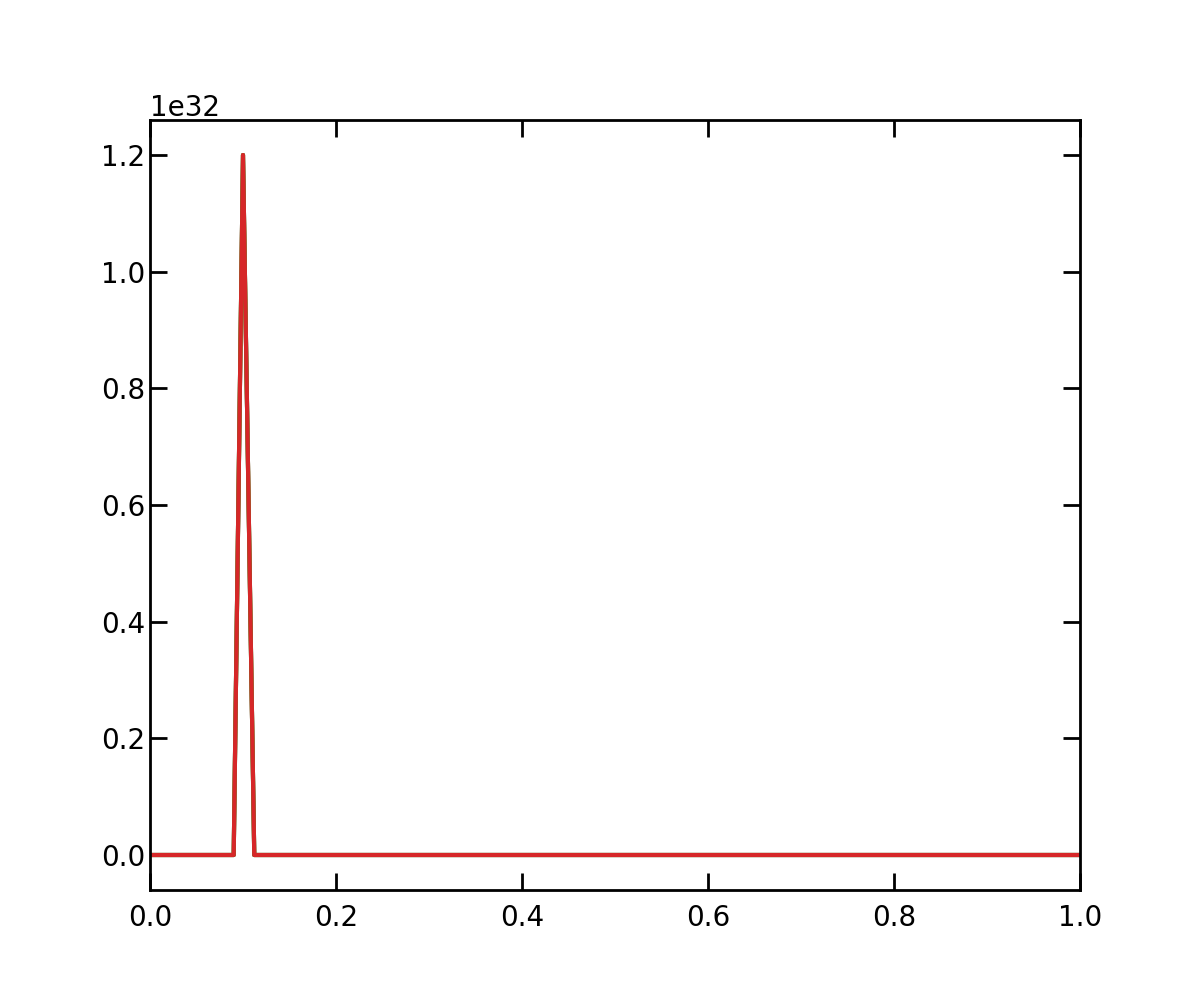

In [6]:
# Prepare the simulation and the tVG input files
# Initialize 
code_name_lst,str_lst,path_lst,tj_lst,tVG_lst,Var_lst,labels = [],[],[],[],[],[],[]
for val in par_vals:
    
    str2run = fixed_str +' -'+par_name+' '+str(val) +' -W_L '+str(val)+ ' -VB_RTL '+str(val) #
    # fixed_str = str(path2devfile) +' -Bulk_tr 1e19 -St_R 0e13 -Cn 9e-13 -Cp 9e-19 -L_RTL 0 -nu_int_RTL 1e1 -'+par_name+' '+str(val)

    ParStrDic = GetParFromStr(str2run)
    L = float(ChosePar('L',ParStrDic,ParFileDic))
    L_LTL = float(ChosePar('L_LTL',ParStrDic,ParFileDic))
    L_RTL = float(ChosePar('L_RTL',ParStrDic,ParFileDic))
    eps_r = float(ParFileDic['eps_r'])
    Lac = L - L_LTL - L_RTL
      
    # Generate tVG files and str_lst for light pulse simulation
    for Gen in Gens:
        for G0 in G0s:
            filename = par_name+'_'+str(val)+'_G_{:.1e}_G0_{:.2e}.txt'.format(Gen,G0)
            zimt_trPL_Gauss_pulse(1e-11, 1e-2, Gen, G0, 1e-10,FWHM=1e-12,tstepmin=1e-11,steps=2000,time_exp = True, tVG_name=os.path.join(path2simu,'tVG_'+filename+'.txt'.format(Gen,G0)))
            str_lst.append(str2run+' -tVG_file tVG_'+filename+'.txt -tj_file tj_'+filename+'.dat -Var_file Var_'+filename+'.dat '.format(Gen,G0,Gen,G0,Gen,G0))
            code_name_lst.append('zimt')
            path_lst.append(path2simu)
            tVG_lst.append('tVG_'+filename+'.txt'.format(Gen,G0))
            tj_lst.append('tj_'+filename+'.dat'.format(Gen,G0))
            Var_lst.append('Var_'+filename+'.dat'.format(Gen,G0))

            # labels.append(f'{val:.2e} Gen = {Gen:.1e} m^-3 s^-1, G0 = {G0:.1e} m^-3 s^-1')

    labels.append(f'{val:.2e}')

plot_tVG = True
if plot_tVG:
    plt.figure()
    for file in tVG_lst:
        df = pd.read_csv(os.path.join(path2simu,file),delim_whitespace=True)
        plt.plot(df['t']/1e-9,df['Gehp'])

        
    plt.xlim(0,1)
    plt.show()


## Run the simulation

In [ ]:
## Run the simulation
run_simu = True
verbose = True
start = time.time()

if run_simu:
    if do_multiprocessing:
        print('Running parallel simulations')
        run_parallel_simu(code_name_lst,path_lst,str_lst,min(max_jobs,len(str_lst)))
    else:
        for i in range(len(str_lst)):
            run_code(code_name_lst[i],path_lst[i],str_lst[i],show_term_output=True,verbose=verbose)
            
print('Calculation time {:.2f} s'.format(time.time() - start)) # Time in seconds

In [ ]:
print(str_lst[0])

## Plot trPL

In [ ]:
colors = cm.viridis((np.linspace(0,1,max(len(Var_lst),4)+1)) ) # Color range for plotting
plt.figure()
for idx,tj_file in enumerate(tj_lst):

    df = pd.read_csv(os.path.join(path2simu,tj_file),delim_whitespace=True)

    plt.loglog(df['t'],df['Jdir']/max(df['Jdir']),label=labels[idx])

plt.xlim(1e-10,1e-2)
plt.ylim(1e-15,2)
plt.xlabel('Time [s]')
plt.ylabel('Norm. PL [a.u.]')
plt.legend(title=par_name)
plt.show()
plt.savefig(os.path.join(path2simu,par_name+'_PL.png'))

## Plot SPV
Here, it is calculated from the carrier density in the perovskite layer alone.

In [ ]:
colors = cm.viridis((np.linspace(0,1,max(len(Var_lst),4)+1)) ) # Color range for plotting
plt.figure()
for idx,var_file in enumerate(Var_lst):

    var_dat = pd.read_csv(os.path.join(path2simu,var_file),delim_whitespace=True, on_bad_lines = 'warn')

    ParStrDic = GetParFromStr(str_lst[idx]) # get parameters from the string
    mun_0 = float(ChosePar('mun_0',ParStrDic,ParFileDic))
    # var_dat = var_dat[var_dat['mun'] == 5e-4]
    var_dat = var_dat[var_dat['mun'] == mun_0] # make sure we are in the perovskite layer
    # var_dat = var_dat[var_dat['x'] > L_LTL]

    grouped = var_dat.groupby('time') # group by time
    

    Bulk_tr = float(ChosePar('Bulk_tr',ParStrDic,ParFileDic))
    St_R = float(ChosePar('St_R',ParStrDic,ParFileDic))

    St = grouped['fti1'].sum() * St_R / Lac # recalculated the interface trap density in m^-3 instead of m^-2
    

    # grouped = var_dat.groupby('time')
    ns = grouped['n'].mean() 
    ps = grouped['p'].mean()
    nions = grouped['nion'].mean() 
    pions = grouped['pion'].mean()

    
    grouped = var_dat.groupby('time')
    nt = grouped['ftb1'].mean() * Bulk_tr # Number of occupied bulk traps in m^-3

    times = ns.index.values 

    # calculate the SPV
    SPV = ((q*Lac**2/2)*(ps-ns-nt-St+pions-nions)/(eps_0*eps_r))
    SPV = np.asarray(SPV)
    SPV = SPV - SPV[0]


    plt.semilogx(times,SPV * 1e3, label = labels[idx])

plt.xlabel('Time [s]')
plt.ylabel('SPV [mV]')
plt.legend(title = par_name)
plt.show()
plt.savefig(os.path.join(path2simu,par_name+'_SPV_dens.png'))


## Plot SPV
Here, it is calculated from the potential in the perovskite and HTL layers.

In [ ]:
colors = cm.viridis((np.linspace(0,1,max(len(Var_lst),4)+1)) ) # Color range for plotting
plt.figure()
for idx,var_file in enumerate(Var_lst):

    var_dat = pd.read_csv(os.path.join(path2simu,var_file),delim_whitespace=True, on_bad_lines = 'warn')

    ParStrDic = GetParFromStr(str_lst[idx]) # get parameters from the string
    mun_0 = float(ChosePar('mun_0',ParStrDic,ParFileDic))

    var_dat = var_dat[var_dat['x'] > L_LTL] # get everything except the insulator
    # var_dat = var_dat[var_dat['mun'] == mun_0] # make sure we are in the perovskite layer

    grouped = var_dat.groupby('time')
    
    SPV = []
    for group in grouped:
        SPV.append(group[1]['V'].iloc[0] - group[1]['V'].iloc[-1]) # calculate the SPV = potential at the insulator/pero interface - potential at the back contact

    SPV = np.asarray(SPV)
    SPV = SPV - SPV[0]

    plt.semilogx(times,SPV*1e3, label = labels[idx])


# exp = pd.read_csv(path2expdata,delimiter=',',names=['t','SPV'],skiprows=1)
# plt.semilogx(exp['t'],exp['SPV']*1e3,label='Exp')

plt.xlabel('Time [s]')
plt.ylabel('SPV [mV]')
plt.legend(title = par_name)
plt.show()
plt.savefig(os.path.join(path2simu,par_name+'_SPV_pot.png'))

## Plot carrier density evolution

In [ ]:
for idx,var_file in enumerate(Var_lst):

    var_dat = pd.read_csv(os.path.join(path2simu,var_file),delim_whitespace=True, on_bad_lines = 'warn')

    # group by time
    times = var_dat['time'].unique()
    colors = cm.viridis((np.linspace(0,1,max(len(times),4)+1)) ) # Color range for plotting
    plt.figure()
    
    for idx2, t in enumerate(times):
        df = var_dat[var_dat['time']==t]
        plt.semilogy(df['x'],df['n'],color=colors[idx2])#,label='n')
        plt.semilogy(df['x'],df['p'],':',color=colors[idx2])#,label='p')
        # put a vertical line at x = L_LTL and x = L - L_RTL
        plt.axvline(x=L_LTL, color='k', linestyle='--')
        plt.axvline(x=L - L_RTL, color='k', linestyle='--')

    plt.ylim(1e9,1e27)
    # create custom legend with ':' is p and '-' is n
    
    custom_lines = [Line2D([0], [0], color='k', linestyle=':'),
                Line2D([0], [0], color='k', linestyle='-')]
    plt.legend(custom_lines, ['p','n'],loc='best')

    plt.xlabel('Position [m]')
    plt.ylabel('Charge carrier density [m^-3]')
    plt.title(par_name+' = '+labels[idx])
    # add colorbar 
    sm = plt.cm.ScalarMappable(cmap=cm.viridis, norm=plt.Normalize(vmin=min(times), vmax=max(times)))
    sm._A = []
    plt.colorbar(sm,label='Time [s]')
    plt.savefig(os.path.join(path2simu,par_name+f'_'+labels[idx]+'_dens.png'))

plt.show()


In [ ]:
plot_ions = False
if plot_ions:
        
    for idx,var_file in enumerate(Var_lst):

        var_dat = pd.read_csv(os.path.join(path2simu,var_file),delim_whitespace=True, on_bad_lines = 'warn')

        # group by time
        times = var_dat['time'].unique()
        colors = cm.viridis((np.linspace(0,1,max(len(times),4)+1)) ) # Color range for plotting
        plt.figure()
        
        for idx2, t in enumerate(times):
            df = var_dat[var_dat['time']==t]
            plt.semilogy(df['x'],df['nion'],color=colors[idx2])#,label='n')
            plt.semilogy(df['x'],df['pion'],':',color=colors[idx2])#,label='p')
            # put a vertical line at x = L_LTL and x = L - L_RTL
            plt.axvline(x=L_LTL, color='k', linestyle='--')
            plt.axvline(x=L - L_RTL, color='k', linestyle='--')

        plt.ylim(1e20,1e23)
        # create custom legend with ':' is p and '-' is n
        
        custom_lines = [Line2D([0], [0], color='k', linestyle=':'),
                    Line2D([0], [0], color='k', linestyle='-')]
        plt.legend(custom_lines, ['pion','nion'],loc='best')

        plt.xlabel('Position [m]')
        plt.ylabel('Charge carrier density [m^-3]')
        plt.title(par_name+' = '+labels[idx])
        # add colorbar
        sm = plt.cm.ScalarMappable(cmap=cm.viridis, norm=plt.Normalize(vmin=min(times), vmax=max(times)))
        sm._A = []
        plt.colorbar(sm,label='Time [s]')
        plt.savefig(os.path.join(path2simu,par_name+f'_'+labels[idx]+'_ions.png'))

    plt.show()

## Plot potential evolution

In [ ]:
colors = cm.viridis((np.linspace(0,1,max(len(times),4)+1)) ) # Color range for plotting
for idx,var_file in enumerate(Var_lst):

    var_dat = pd.read_csv(os.path.join(path2simu,var_file),delim_whitespace=True, on_bad_lines = 'warn')

    # group by time
    times = var_dat['time'].unique()
    colors = cm.viridis((np.linspace(0,1,max(len(times),4)+1)) ) # Color range for plotting
    plt.figure()

    for idx2, t in enumerate(times):
        df = var_dat[var_dat['time']==t]
        plt.plot(df['x'],df['V'],color=colors[idx2])#,label='n')


    plt.xlabel('Position [m]')
    plt.ylabel('Potential [V]')
    plt.title(par_name+' = '+labels[idx])
    # add colorbar
    sm = plt.cm.ScalarMappable(cmap=cm.viridis, norm=plt.Normalize(vmin=min(times), vmax=max(times)))
    sm._A = []
    plt.colorbar(sm,label='Time [s]')
    plt.savefig(os.path.join(path2simu,par_name+f'_'+labels[idx]+'_pot.png'))
    
plt.show()

In [ ]:
# Clean output files from simulation folders
Do_Cleaning = False # Careful, this will delete all files in the folder
if Do_Cleaning:
    clean_up_output('tj',path2simu)
    clean_up_output('tVG',path2simu)
    clean_up_output('JV',path2simu)
    clean_up_output('Var',path2simu)
    clean_up_output('scPars',path2simu)
    clean_up_output('log',path2simu)
    clean_up_output('Str4Parallel',path2simu)
    clean_up_output('joblog',path2simu)
    clean_file_type('.jpg',path2simu) # clean all jpg files
    clean_file_type('.png',path2simu) # clean all png files
else:
    clean_up_output('log',path2simu)
    clean_up_output('Str4Parallel',path2simu)
    clean_up_output('joblog',path2simu)
    